# libraries

In [1]:
# data processing
import torch

# signal processing
import mne
mne.set_log_level('WARNING') # output less verbose

# visualization
%matplotlib qt
#%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
fs = 200
n_channels = 65

# load data

In [3]:
data_file = 'data/data_Dinh_fs200.pt'
labels_file = 'data/labels_Dinh_fs200.pt'

In [4]:
data = torch.load(data_file)
data.shape

torch.Size([189, 65, 55000])

In [5]:
labels = torch.load(labels_file)
print(labels.shape)
print(labels.unique())

torch.Size([189])
tensor([0, 1, 2, 3])


## load into mne

In [6]:
#ch_names = [f'EEG {n:02}' for n in range(1, 66)]
ch_types = ['eeg'] * n_channels
info = mne.create_info(n_channels, sfreq=fs, ch_types=ch_types)
patient_data = mne.io.RawArray(data=data[0], info=info)
patient_data

<RawArray | 65 x 55000 (275.0 s), ~27.3 MB, data loaded>

In [7]:
#patient_data.get_data()

In [8]:
patient_data.get_data().shape

(65, 55000)

In [9]:
len(patient_data)

55000

## crop (time domain)

In [10]:
patient_data.copy().crop(tmin=100, tmax=200)

<RawArray | 65 x 20001 (100.0 s), ~10.0 MB, data loaded>

## drop channels

In [11]:
patient_data.copy().drop_channels(['15', '30'])

<RawArray | 63 x 55000 (275.0 s), ~26.5 MB, data loaded>

## filter (freq domain)

In [12]:
# between 1 and 4hz
patient_data.copy().filter(1, 20)

<RawArray | 65 x 55000 (275.0 s), ~27.3 MB, data loaded>

## plot

In [13]:
patient_data.info

<Info | 7 non-empty values
 bads: []
 ch_names: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, ...
 chs: 65 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 100.0 Hz
 meas_date: unspecified
 nchan: 65
 projs: []
 sfreq: 200.0 Hz
>

In [14]:
patient_data.plot(n_channels=20)

In [15]:
patient_data.plot(start=60, duration=120, n_channels=10)

In [16]:
patient_data.plot(duration=60, n_channels=len(patient_data.ch_names))

## power vs frequency - PSD

In [17]:
spectrum = patient_data.compute_psd()
spectrum

Data type,Power Spectrum
Units,eeg: V²/Hz
Data source,Raw
Dims,"channel, freq"
Estimation method,welch
Number of channels,65
Number of frequency bins,129
Frequency range,0.00 – 100.00 Hz


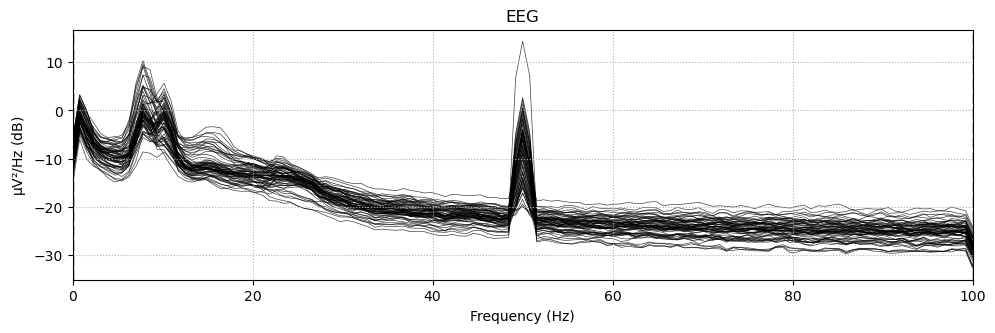

In [18]:
spectrum.plot()

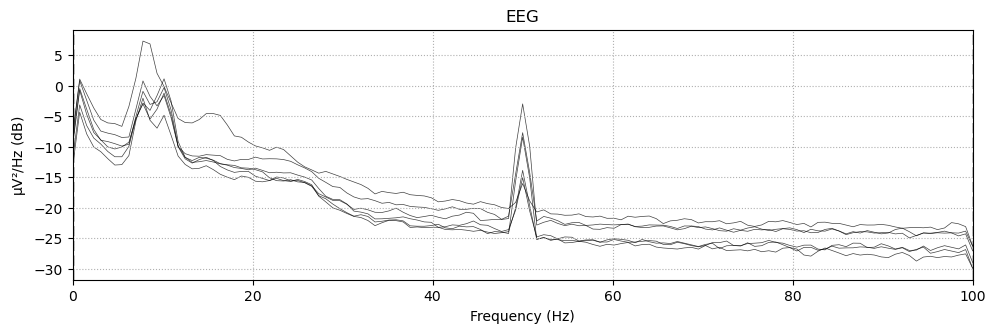

In [19]:
channels = ['2', '12', '30', '48', '58', '60']
spectrum.plot(picks=channels)

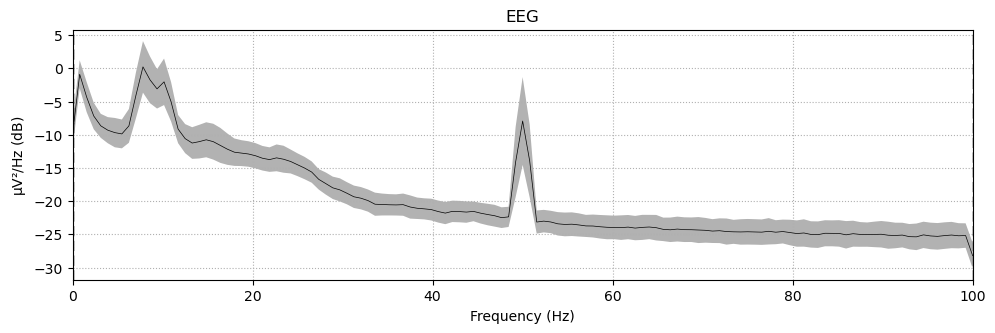

In [20]:
spectrum.plot(average=True)

Most of the useful information in EEG is located between 0 and 40 Hz

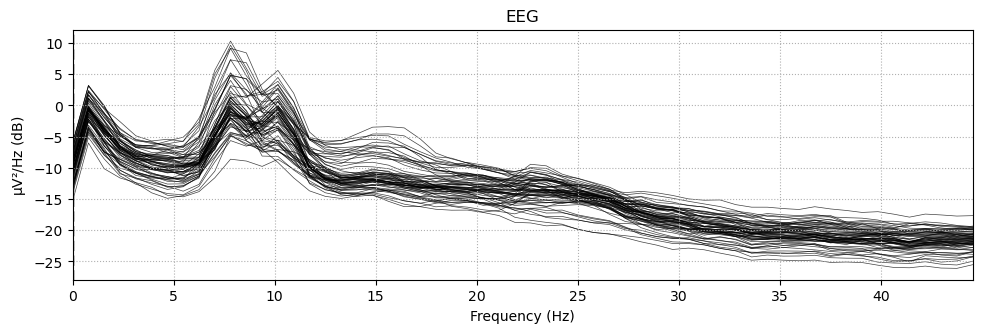

In [21]:
patient_data.compute_psd(fmax=45).plot()

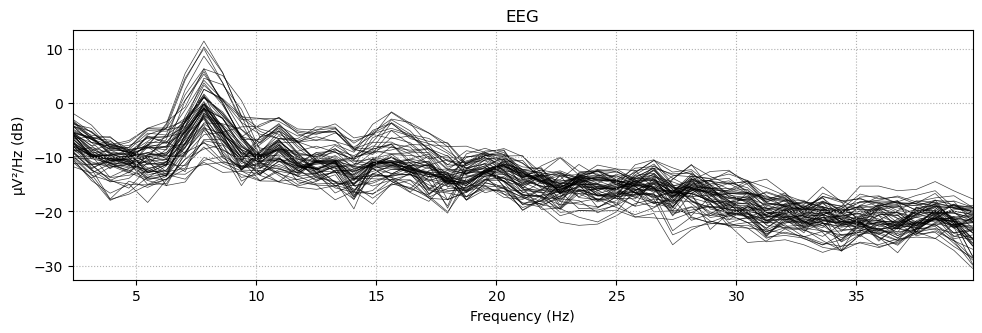

In [22]:
patient_data.compute_psd(tmin=10, tmax=20, fmin=2, fmax=40).plot()

## notch filter

In [23]:
modified = patient_data.copy().notch_filter(freqs=50)
modified

<RawArray | 65 x 55000 (275.0 s), ~27.3 MB, data loaded>

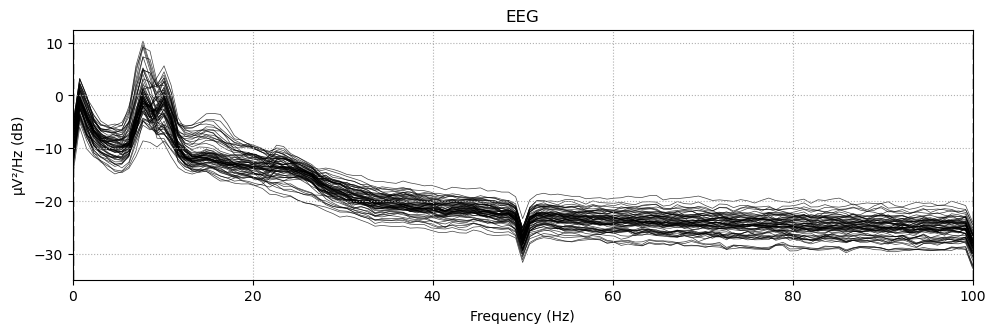

In [24]:
modified.compute_psd().plot()

## epochs

epochs = experiments

In [25]:
data.shape

torch.Size([189, 65, 55000])

In [26]:
all_patients = mne.EpochsArray(data, info)

In [27]:
all_patients.get_data().shape

(189, 65, 55000)

In [28]:
all_patients.average()

<Evoked | '1' (average, N=189), 0 – 275 sec, baseline off, 65 ch, ~27.3 MB>

### filter

In [29]:
all_patients.filter(l_freq=0.5, h_freq=45)

Number of events,189
Events,1: 189
Time range,0.000 – 274.995 sec
Baseline,off


In [30]:
all_patients.info

<Info | 7 non-empty values
 bads: []
 ch_names: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, ...
 chs: 65 EEG
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 45.0 Hz
 meas_date: unspecified
 nchan: 65
 projs: []
 sfreq: 200.0 Hz
>

### crop

In [31]:
all_patients.crop(tmin=0, tmax=60)

Number of events,189
Events,1: 189
Time range,0.000 – 60.000 sec
Baseline,off


In [32]:
all_patients.info

<Info | 7 non-empty values
 bads: []
 ch_names: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, ...
 chs: 65 EEG
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 45.0 Hz
 meas_date: unspecified
 nchan: 65
 projs: []
 sfreq: 200.0 Hz
>

In [33]:
all_patients.get_data().shape

(189, 65, 12001)

### dataframe

In [34]:
df = all_patients.to_data_frame()
df.head()

,time,condition,epoch,0,1,2,3,4,5,6,...,55,56,57,58,59,60,61,62,63,64
0,0.000,1,0,1.778697,2.018200,1.604558,1.159216,0.760800,-0.481028,-0.435075,...,0.306292,0.333062,-1.566786,-0.966611,-2.855181,2.212234,-2.092693,-0.518125,-1.576975,3.291353
1,0.005,1,0,1.515212,2.099011,1.074283,1.683209,1.285427,0.241545,-0.491844,...,0.452596,-0.450036,-1.591879,-1.867092,-2.860510,1.905318,-2.688150,0.065973,-1.658072,3.991907
2,0.010,1,0,2.026617,2.699072,1.026404,2.301979,1.434030,0.443005,-0.597633,...,0.286043,-1.594192,-1.871093,-3.674117,-2.204374,2.035189,-2.626519,0.909933,-2.104194,4.606690
3,0.015,1,0,2.181483,2.847111,0.809030,1.938061,0.254176,-0.261388,-0.650804,...,0.426519,-1.598795,-1.017269,-4.477268,-0.360156,2.145011,-0.374984,0.385065,-2.066803,3.195492
4,0.020,1,0,1.176411,1.807607,-0.011208,0.548904,-1.744721,-1.135487,-0.503866,...,0.558153,-0.916552,0.638305,-3.122958,2.606951,1.482247,3.051675,-1.060524,-0.653832,0.437594


In [35]:
df.shape

(2268189, 68)

In [36]:
df.tail()

,time,condition,epoch,0,1,2,3,4,5,6,...,55,56,57,58,59,60,61,62,63,64
2268184,59.980,1,188,1.696818,1.647036,8.500303,2.568708,14.611882,-5.179316,-1.246382,...,-3.095478,-0.146051,-4.113638,-9.325042,-7.725883,1.994004,-3.738664,2.311761,-12.724043,13.087251
2268185,59.985,1,188,2.865137,1.069901,8.038188,3.014980,11.863043,-2.547077,-4.472373,...,-1.960825,-1.068271,-2.029890,-12.269905,-7.124380,1.784335,-3.861446,-0.085769,-11.854360,13.539524
2268186,59.990,1,188,4.132698,2.340832,4.397906,1.803398,4.023803,-1.335987,-4.117332,...,1.726348,0.089878,1.811758,-8.535432,-3.146844,2.899316,-0.678714,-4.924454,-8.728620,2.187203
2268187,59.995,1,188,-1.116587,-0.286322,-1.716104,-2.205843,-0.862823,1.531623,0.363456,...,1.591417,-0.349909,3.695669,-2.397490,1.565260,-0.739788,1.367335,-0.938439,-2.877390,-6.524957
2268188,60.000,1,188,-7.893654,-6.617277,-6.290799,-6.752900,0.264820,4.947747,3.563667,...,-2.511931,-2.624051,3.021913,-1.852713,3.367287,-7.532394,-0.104545,8.576457,3.296085,-4.623331


## downsampling

In [37]:
patient_data

<RawArray | 65 x 55000 (275.0 s), ~27.3 MB, data loaded>

In [38]:
# set sampling frequency to 100Hz
patient_data_resamp = patient_data.copy().resample(100, npad='auto')
patient_data_resamp

<RawArray | 65 x 27500 (275.0 s), ~13.7 MB, data loaded>

In [39]:
#all_patients.copy().resample(100).get_data()
#all_patients.copy().decimate(2)

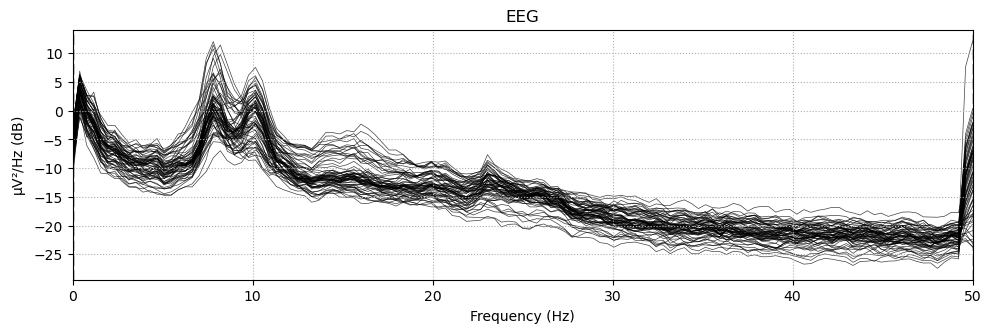

In [40]:
patient_data_resamp.compute_psd().plot()

In [41]:
patient_data.plot(n_channels=10)

In [42]:
patient_data_resamp.plot(n_channels=10)